<a href="https://colab.research.google.com/github/Crazytiger0527/Study_Pytorch/blob/main/bos_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [ ]:
bos = load_boston()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df['Price'] = bos.target
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [ ]:
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1,1))

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

In [ ]:
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]
  
  def __len__(self):
    return self.len

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [ ]:
class Regressor(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True)
    self.fc2 = nn.Linear(50, 30, bias=True)
    self.fc3 = nn.Linear(30, 1, bias=True)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.relu(self.fc3(x))

    return x

In [ ]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-7)

In [ ]:
loss_ = []
n = len(trainloader)

for epoch in range(400):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, values)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  loss_.append(np.sqrt(running_loss)/n)
print('Finished Training')

Finished Training


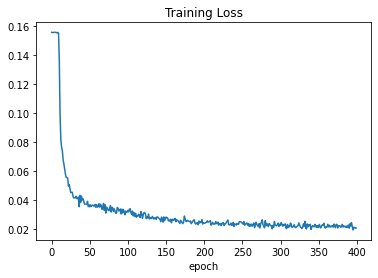

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float)
  actual = torch.tensor([], dtype=torch.float)

  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0)
      actual = torch.cat((actual,values), 0)

  predictions = predictions.numpy()
  actual = actual.numpy()
  rmse = np.sqrt(mean_squared_error(predictions, actual))

  return rmse

In [ ]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)

print("Train: ", train_rmse)
print("Test: ", test_rmse)

Train:  0.043991815
Test:  0.080032654
